# Digital Elevation Model

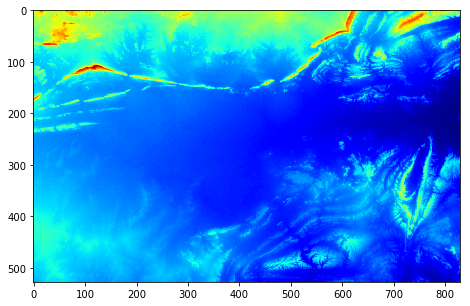

In [21]:
# read
tif = gdal.Open('AliceDEM.tif')
slope = tif.ReadAsArray()

# plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.imshow(slope, cmap='jet')

# Add paths for QGis

In [1]:
import sys
sys.path.append('/Applications/QGIS.app/Contents/Resources/python/')

In [2]:
from qgis.core import *

In [3]:
sys.path.append('/Applications/QGIS.app/Contents/Resources/python/plugins/')

In [4]:
# for gdal...
sys.path.extend(['', '/Library/Frameworks/SQLite3.framework/Versions/C/Python/2.7', '/Library/Frameworks/GEOS.framework/Versions/3/Python/2.7/site-packages', '/Library/Python/2.7/site-packages/numpy-override', '/Library/Python/2.7/site-packages/matplotlib-override', '/Library/Frameworks/GDAL.framework/Versions/2.1/Python/2.7/site-packages', '/Library/Python/2.7/site-packages/pyobjc-2.5.1-py2.7.egg', '/Library/Python/2.7/site-packages/numpy-1.12.0-py2.7-macosx-10.11-intel.egg', '/Library/Python/2.7/site-packages/six-1.10.0-py2.7.egg', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/jonathan/Library/Python/2.7/lib/python/site-packages', '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/PyObjC', '/Library/Python/2.7/site-packages'])

In [5]:
import processing

In [6]:
from processing import *

In [7]:
sys.path.append('/Applications/QGIS.app/Contents/Resources/python/plugins/processing/')
from processing.core.Processing import Processing

In [8]:
app = QgsApplication([], True)

In [9]:
QgsApplication.setPrefixPath("/Applications/QGIS.app/Contents/MacOs/", True)
QgsApplication.initQgis()

In [10]:
Processing.initialize()

In [13]:
processing.alghelp('gdalogr:slope')

ALGORITHM: Slope
	INPUT <ParameterRaster>
	BAND <ParameterNumber>
	COMPUTE_EDGES <ParameterBoolean>
	ZEVENBERGEN <ParameterBoolean>
	AS_PERCENT <ParameterBoolean>
	SCALE <ParameterNumber>
	OUTPUT <OutputRaster>





In [31]:
# list all available algorithms:
# processing.alglist()

# QGIS calculate slope

In [15]:
from PyQt4.QtCore import QFileInfo 
fileName = "/Users/jonathan/dev/geohackautumn2017/GAHack/AliceDEM.tif"
fileInfo = QFileInfo(fileName)
baseName = fileInfo.baseName()
rlayer = QgsRasterLayer(fileName, baseName)
if not rlayer.isValid():
    print "Layer failed to load!"

slope = "/Users/jonathan/dev/geohackautumn2017/GAHack/slope.tif"

In [16]:
# https://docs.qgis.org/2.6/en/docs/user_manual/processing/scripts.html

processing.runalg("gdalogr:slope", rlayer, 1, True, True, False, 1.0, slope)

{'OUTPUT': '/Users/jonathan/dev/geohackautumn2017/GAHack/slope.tif'}

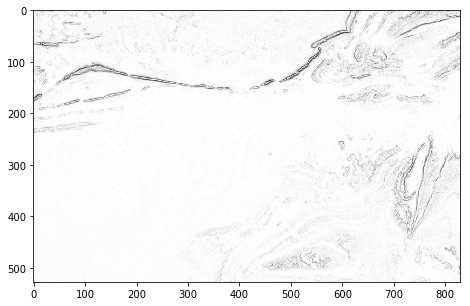

In [19]:
# read
tif = gdal.Open('slope.tif')
slope = tif.ReadAsArray()

# plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.imshow(slope, cmap='Greys')

# gdaldem command line tool

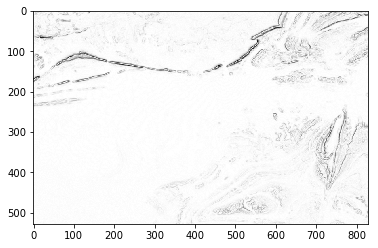

In [25]:
# slope
import os
output_slope_map = "slope_map.tif"
input_dem = 'AliceDEM.tif'
slope_command = "gdaldem slope -s 111120 -compute_edges {input_dem} {output_slope_map}"

os.system(slope_command.format(input_dem=input_dem, output_slope_map=output_slope_map))

dataset = gdal.Open(output_slope_map)

slope_array = dataset.GetRasterBand(1).ReadAsArray()
plt.imshow(slope_array, cmap='Greys')

# pure python

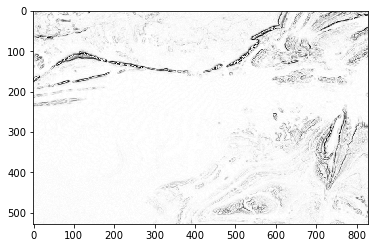

In [27]:
# http://gis.stackexchange.com/questions/18319/calculating-slope-cell-by-cell-in-arcpy
import numpy
from scipy.ndimage import generic_filter

def calc_slope(in_filter, x_cellsize, y_cellsize):
    #slope calculation here - note need to reshape in array to be 3*3
    if -9999 in in_filter:
        return -9999 #Will return -9999 around edge with mode constant and cval -9999
    else:
        [a, b, c, d, e, f, g, h, i] = in_filter
        #From 3x3 box, row 1: a, b, c
        #              row 2: d, e, f
        #              row 3: g, h, i

        dz_dx = ((c + 2*f + i) - (a + 2 * d + g)) / (8 * float(x_cellsize))
        dz_dy = ((g + 2*h + i) - (a + 2 * b + c)) / (8 * float(y_cellsize))
        slope = numpy.sqrt(dz_dx ** 2 + dz_dy**2)

        return numpy.degrees(slope) #we want slope in degrees rather than radians

ds = gdal.Open('AliceDEM.tif')  
band = ds.GetRasterBand(1)  
array = band.ReadAsArray()

#slope will return a numpy array the sme size and dimensions as the input raster_data
slope = generic_filter(array, calc_slope, size=3, mode='constant',
                       cval=-9999, extra_arguments=(3, 3))
plt.imshow(slope, cmap='Greys')